# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
    - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
    - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip
    
Note that even if we are estimating a time serie, we are not using here a recurrent neural network as we assume the temporal dependence to be negligible (i.e. Y_t = f(X_t) alone).

In [49]:
###########################################################################################
### With scaling of the X, correction of measure unit for Y & dummification (but no PCA)...
###########################################################################################

using LinearAlgebra, Random, DataFrames, CSV, StatsPlots, Distributions
using BetaML.Nn

import Random:seed!
seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [50]:
# Data loading and cleaning..
baseDir = "assets/bikeSharingDemandForecast/"
data = CSV.read(joinpath(baseDir,"bike_sharing_day.csv"),delim=',',copycols=true)
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,instant,366.0,1,366.0,731,,,Int64
2,dteday,,2011-01-01,,2012-12-31,731,,Date
3,season,2.49658,1,3.0,4,,,Int64
4,yr,0.500684,0,1.0,1,,,Int64
5,mnth,6.51984,1,7.0,12,,,Int64
6,holiday,0.0287278,0,0.0,1,,,Int64
7,weekday,2.99726,0,3.0,6,,,Int64
8,workingday,0.683995,0,1.0,1,,,Int64
9,weathersit,1.39535,1,1.0,3,,,Int64


In [51]:
seasonDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:season]))
weatherDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:weathersit]))
wdayDummies = convert(Array{Float64,2},oneHotEncoder(data[:,:weekday] .+ 1 ))

x    = hcat(convert(Array{Float64,2},data[:,[:instant,:yr,:mnth,:holiday,:workingday,:temp,:atemp,:hum,:windspeed]]),
            seasonDummies,
            weatherDummies,
            wdayDummies)
y    = data[:,16] 
colsNotToScale = [2;4;5;10:23]

# Split the data in training/testing sets
ntrain    = Int64(round(size(x,1)*0.75))
nval      = Int64(round(size(x,1)*0.125))
ntest     = size(x,1) - (ntrain+nval)
xtrain    = x[1:ntrain,:]
ytrain    = y[1:ntrain]
xval      = x[(ntrain+1):(ntrain+nval),:]
yval      = y[(ntrain+1):(ntrain+nval)]
xtest     = x[ntrain+nval+1:end,:]
ytest     = y[ntrain+nval+1:end]

xScaleFactors = getScaleFactors(xtrain,skip=colsNotToScale)
yScaleFactors = ([0],[0.001]) # getScaleFactors(ytrain) # This just divide by 1000. Using full scaling of Y we may get negative demand.

xtrainScaled = Utils.scale(xtrain,xScaleFactors)

xvalScaled   = Utils.scale(xval,xScaleFactors)
xtestScaled  = Utils.scale(xtest,xScaleFactors)
ytrainScaled = Utils.scale(ytrain,yScaleFactors)
out    = pca(xtrainScaled,error=0.05)
xtrainScaledPca = xtrainScaled #out.X  # change these lines if you want to run PCA (doesn't seem to improve)
xvalScaledPca   = xvalScaled   #xvalScaled*out.P
xtestScaledPca  = xtestScaled  #xtestScaled*out.P
D = size(xtrainScaledPca,2)

23

In [19]:
# Train using validation set to select the hyperpharameters (may take a while)
epochsToTest = [10,20,40,80,160,320,640,1200]
hiddenLayerSizes = [5,8,12,15,20,25,30]
bestEpoch = 0
bestSize = 0
bestValError = Inf
errorsMatrix5 = fill(Inf64,length(epochsToTest),length(hiddenLayerSizes))

for (ne,epoch) in enumerate(epochsToTest), (nls,ls) in enumerate(hiddenLayerSizes)

    global bestValError, bestSize, errorsMatrix5, bestEpoch
    println("Testing epochs $epoch, layer size $ls ...")
    l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
    l2   = DenseLayer(ls,1,f=identity, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
    mynn = buildNetwork([l1,l2],squaredCost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

    # Training it (default to ADAM)
    res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batchSize=8,optAlg=ADAM(),verbosity=NONE) # Use optAlg=SGD (Stochastic Gradient Descent) by default
    ŷval = Utils.scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true)
    
    meanRelErrorVal   = meanRelError(ŷval,yval)
    if meanRelErrorVal < bestValError
        bestValError = meanRelErrorVal
        bestSize = ls
        bestEpoch = epoch
    end
    errorsMatrix5[ne,nls] = meanRelErrorVal
end

errorsMatrix5

Testing epochs 10, layer size 5 ...
Testing epochs 10, layer size 8 ...
Testing epochs 10, layer size 12 ...
Testing epochs 10, layer size 15 ...
Testing epochs 10, layer size 20 ...
Testing epochs 10, layer size 25 ...
Testing epochs 10, layer size 30 ...
Testing epochs 20, layer size 5 ...
Testing epochs 20, layer size 8 ...
Testing epochs 20, layer size 12 ...
Testing epochs 20, layer size 15 ...
Testing epochs 20, layer size 20 ...
Testing epochs 20, layer size 25 ...
Testing epochs 20, layer size 30 ...
Testing epochs 40, layer size 5 ...
Testing epochs 40, layer size 8 ...
Testing epochs 40, layer size 12 ...
Testing epochs 40, layer size 15 ...
Testing epochs 40, layer size 20 ...
Testing epochs 40, layer size 25 ...
Testing epochs 40, layer size 30 ...
Testing epochs 80, layer size 5 ...
Testing epochs 80, layer size 8 ...
Testing epochs 80, layer size 12 ...
Testing epochs 80, layer size 15 ...
Testing epochs 80, layer size 20 ...
Testing epochs 80, layer size 25 ...
Testing e

8×7 Array{Float64,2}:
 0.642687  0.420673  0.504264  0.274482  0.160844  0.153734  0.133197
 0.283178  0.203433  0.199212  0.153144  0.144168  0.149114  0.133432
 0.227418  0.152391  0.156832  0.136376  0.135144  0.131896  0.130061
 0.123529  0.125179  0.119302  0.116708  0.120166  0.113945  0.120187
 0.127481  0.112116  0.110524  0.126145  0.113918  0.121176  0.132569
 0.145099  0.132298  0.110138  0.14127   0.11766   0.131785  0.133528
 0.160986  0.137969  0.166686  0.17182   0.140722  0.164565  0.16232
 0.142474  0.116464  0.118003  0.137263  0.163332  0.120923  0.11516

In [54]:
# Re-doing training with the best hyperparameters:
ls    = bestSize
epoch = bestEpoch

println("Final training of $epoch epochs, with layer size $ls ...")
# Note that the Xavier initialisation is now by default, so you don't need to specify w and wb to get it...
l1   = DenseLayer(D,ls,f=sigmoid, w=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls,D), wb=rand(Uniform(-sqrt(6)/sqrt(D+ls),sqrt(6)/sqrt(D+ls)),ls)   ) # Activation function is ReLU
l2   = DenseLayer(ls,ls,f=relu, w=rand(Uniform(-sqrt(6)/sqrt(ls+ls),sqrt(6)/sqrt(ls+ls)),ls,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+ls),sqrt(6)/sqrt(ls+ls)),ls) )
l3   = DenseLayer(ls,1,f=identity, w=rand(Uniform(-sqrt(6)/sqrt(1+15),sqrt(6)/sqrt(1+15)),1,ls), wb=rand(Uniform(-sqrt(6)/sqrt(ls+1),sqrt(6)/sqrt(ls+1)),1) )
mynn = buildNetwork([l1,l3],squaredCost,name="Bike sharing regression model") # Build the NN and use the squared cost (aka MSE) as error function

# Training it (default to ADAM)
res  = train!(mynn,xtrainScaledPca,ytrainScaled,epochs=epoch,batchSize=8,optAlg=ADAM()) # Use optAlg=SGD (Stochastic Gradient Descent) by default

Final training of 320 epochs, with layer size 12 ...
***
*** Training Bike sharing regression model for 320 epochs with algorithm ADAM.
Training.. 	 avg ϵ on (Epoch 1 Batch 68): 	 5.746266765668068


Training the Neural Network... 10%|██▏                  |  ETA: 0:00:09

Training.. 	 avg ϵ on (Epoch 32 Batch 68): 	 0.09767903554925238
Training.. 	 avg ϵ on (Epoch 64 Batch 68): 	 0.15382683480824352


Training the Neural Network... 21%|████▌                |  ETA: 0:00:08

Training.. 	 avg ϵ on (Epoch 96 Batch 68): 	 0.19050043061570568


Training the Neural Network... 32%|██████▊              |  ETA: 0:00:06

Training.. 	 avg ϵ on (Epoch 128 Batch 68): 	 0.08917944698474783


Training the Neural Network... 42%|████████▊            |  ETA: 0:00:06

Training.. 	 avg ϵ on (Epoch 160 Batch 68): 	 0.07628258898059996


Training the Neural Network... 53%|███████████▏         |  ETA: 0:00:05

Training.. 	 avg ϵ on (Epoch 192 Batch 68): 	 0.11366104593550286


Training the Neural Network... 65%|█████████████▋       |  ETA: 0:00:03

Training.. 	 avg ϵ on (Epoch 224 Batch 68): 	 0.10043902512805669


Training the Neural Network... 76%|████████████████     |  ETA: 0:00:02

Training.. 	 avg ϵ on (Epoch 256 Batch 68): 	 0.10589584157342465


Training the Neural Network... 88%|██████████████████▌  |  ETA: 0:00:01

Training.. 	 avg ϵ on (Epoch 288 Batch 68): 	 0.061881633900903385


Training the Neural Network...100%|█████████████████████| Time: 0:00:09


Training.. 	 avg ϵ on (Epoch 320 Batch 68): 	 0.024300297152764497
Training of 320 epoch completed. Final epoch error: 0.08593362506125143.


(epochs = 320, ϵ_epochs = [6.929156194209404, 4.828947568624644, 3.163549799488969, 2.036458586428853, 1.3502107157928065, 0.9676939935206597, 0.7480640573023475, 0.6231838317590137, 0.5403786498336964, 0.48018542415827287  …  0.08642615206532595, 0.08612013720166943, 0.08606791686197411, 0.08604060292127456, 0.08589589617491167, 0.08701731965214156, 0.08598269936895857, 0.08569558959994213, 0.08609669690174791, 0.08593362506125143], θ_epochs = Any[])

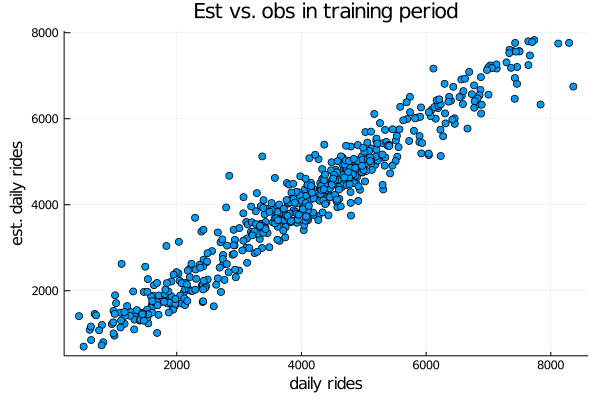

In [55]:
ŷtrain  = Utils.scale(predict(mynn,xtrainScaledPca),yScaleFactors,rev=true)
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

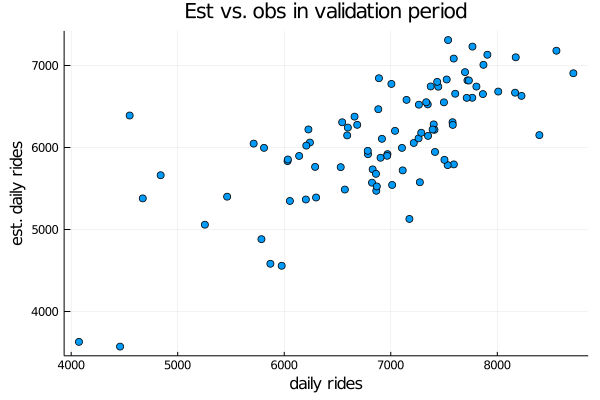

In [56]:
ŷval = Utils.scale(predict(mynn,xvalScaledPca),yScaleFactors,rev=true)
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

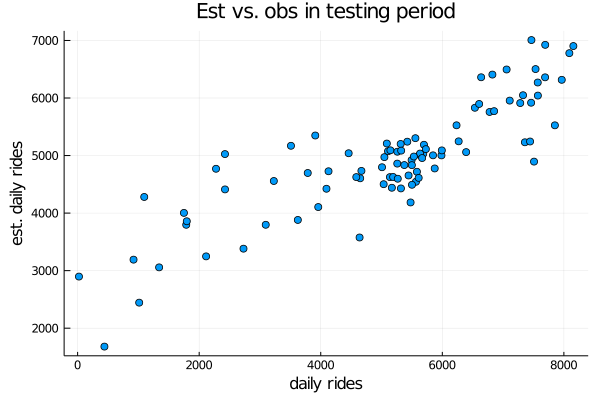

In [57]:
ŷtest  = Utils.scale(predict(mynn,xtestScaledPca),yScaleFactors,rev=true)
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

In [63]:
mean(abs.(ŷtest .- ytest))/(mean(ytest)*length(ytest))

0.0020994127762456252

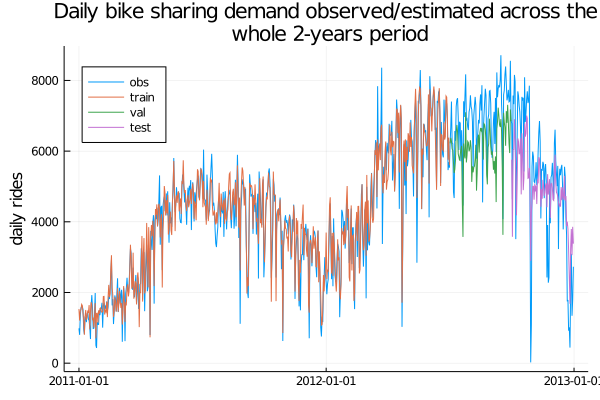

In [64]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

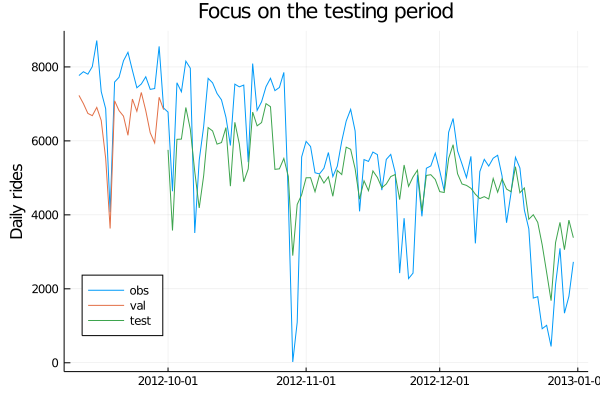

In [65]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

## Comparation with Flux

Disclaimer: I'm a nebbie with [Flux](https://fluxml.ai/), this is likelly not to be the best approach

In [67]:
using Flux

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260


In [68]:
# Defining the net model and load it with data...
Flux_nn = Chain(Dense(D,ls,Flux.sigmoid),
                Dense(ls,1,identity))

loss(x, y) = Flux.mse(Flux_nn(x), y)
ps = Flux.params(Flux_nn)
nndata = Flux.Data.DataLoader(xtrainScaledPca', ytrainScaled', batchsize=8) 

Flux.Data.DataLoader(([-1.728893009486523 -1.722571645649278 … 1.722571645649278 1.728893009486523; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 1.0 0.0 … 1.0 0.0], [0.985 0.801 … 5.687 5.531]), 8, 548, true, 548, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  539, 540, 541, 542, 543, 544, 545, 546, 547, 548], false)

In [69]:
# Training of the Flux model...
Flux.@epochs epoch Flux.train!(loss, ps, nndata, Flux.ADAM(0.001, (0.9, 0.8)))

┌ Info: Epoch 1
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 2
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 3
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 4
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 5
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 6
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 7
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 8
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 9
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 10
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 11
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/s

┌ Info: Epoch 95
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 96
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 97
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 98
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 99
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 100
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 101
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 102
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 103
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 104
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 105
└ @ Main /home/lobianco/.julia/packag

┌ Info: Epoch 183
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 184
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 185
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 186
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 187
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 188
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 189
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 190
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 191
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 192
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 193
└ @ Main /home/lobianco/.julia/p

┌ Info: Epoch 275
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 276
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 277
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 278
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 279
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 280
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 281
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 282
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 283
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 284
└ @ Main /home/lobianco/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121
┌ Info: Epoch 285
└ @ Main /home/lobianco/.julia/p

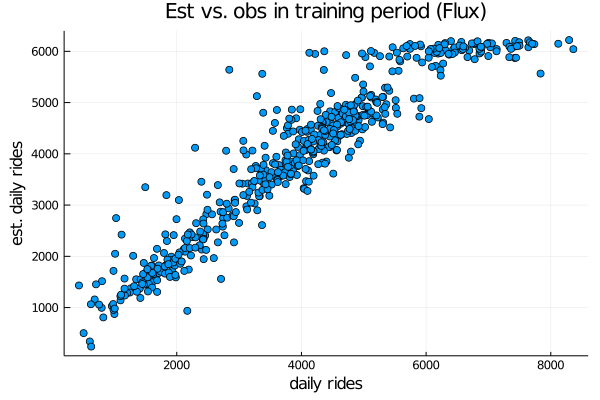

In [70]:
ŷtrainf = Utils.scale(Flux_nn(xtrainScaledPca')',yScaleFactors,rev=true)
scatter(ytrain,ŷtrainf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period (Flux)")

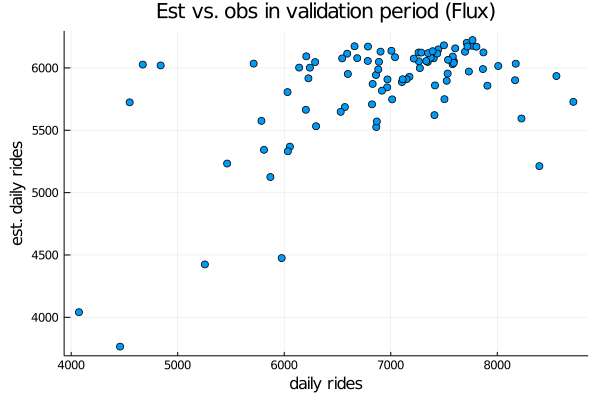

In [71]:
ŷvalf = Utils.scale(Flux_nn(xvalScaledPca')',yScaleFactors,rev=true)
scatter(yval,ŷvalf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period (Flux)")

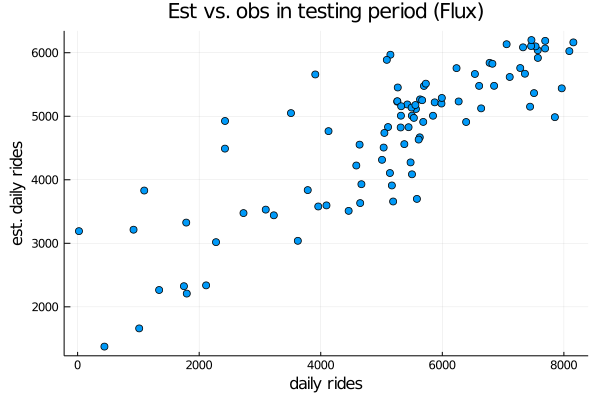

In [72]:
ŷtestf  = Utils.scale(Flux_nn(xtestScaledPca')',yScaleFactors,rev=true)
scatter(ytest,ŷtestf,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period (Flux)")

In [74]:
mean(abs.(ŷtestf .- ytest))/(mean(ytest)*length(ytest))

0.0021381548542334984

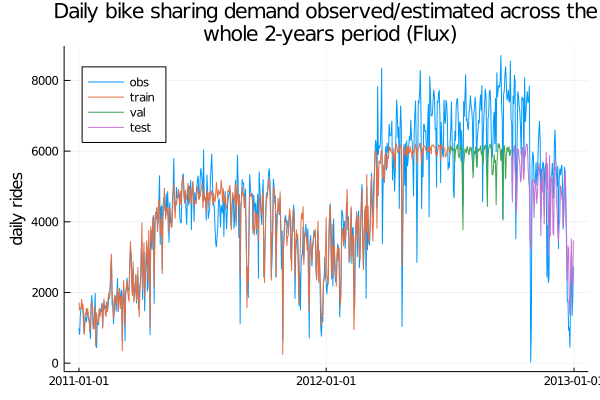

In [75]:
# Full period plot (2 years)
ŷtrainfullf = vcat(ŷtrainf,fill(missing,nval+ntest))
ŷvalfullf = vcat(fill(missing,ntrain), ŷvalf, fill(missing,ntest))
ŷtestfullf = vcat(fill(missing,ntrain+nval), ŷtestf)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfullf ŷvalfullf ŷtestfullf], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period (Flux)")

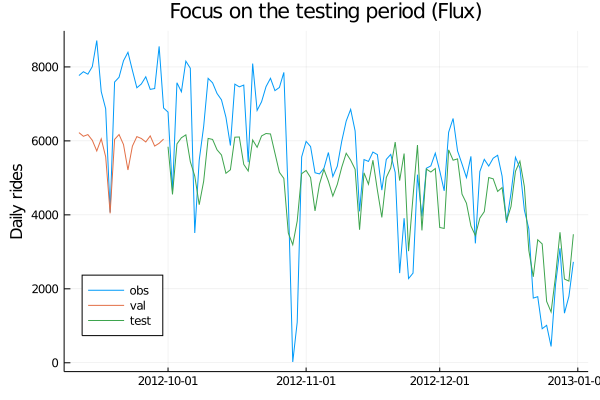

In [76]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfullf[stc:endc] ŷtestfullf[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period (Flux)")